# Optical Flow Spoofing a Live Drone (-5deg/s Strength)
In this analysis we will be looking at a quadcopter flown to several meters up,
set to loiter mode, and then optical flow spoofing simulated on the autopilot.
The optical flow spoofing attack written into the autopilot is enabled by
parameters in the ground control station (GCS) with no end target for the
spoofing but rather injecting -5deg/s every update. The expectation is for the
autopilot to interpret the optical flow readings as the drone suddenly tilting
and respond by attempting to stabilize the quiadcopter which in actuallity will
send the drone veering off course.

The data file can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.


For additional information about each sensor pair used in confirmation or a
more detailed explanation of the process refer to the no attack
[exploration notebook](./0.1-bks-exploration.ipynb) using simulation data.

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-OF-5deg.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

## Gyroscope, Magnetometer, and Optical Flow
Most of the information related to these sensors we will be looking at is
already explained in the [simulation notebook](./0.1-bks-exploration.ipynb)
and won't be reiterated here. The initial assessment of the signals and details
about integrating one or deriving another to get confirmable results will still
be presented as they provide some insights into the behavior of live sensor
data that won't be found in the simulation notebook.

In [2]:
#Get rid of duplicate rows
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR"]].reset_index()
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz"]].reset_index()

#Assign relevant variables
atk = 233399566
times = [0, atk/1000]

#### Gyroscope

We will demonstrate how the raw gyroscope readings are turned into usable
attitude measurements. Only the roll rate will be demonstrated here as the
attack was on the roll rate of the optical flow sensor. Further confirmation
details will be looked at later.

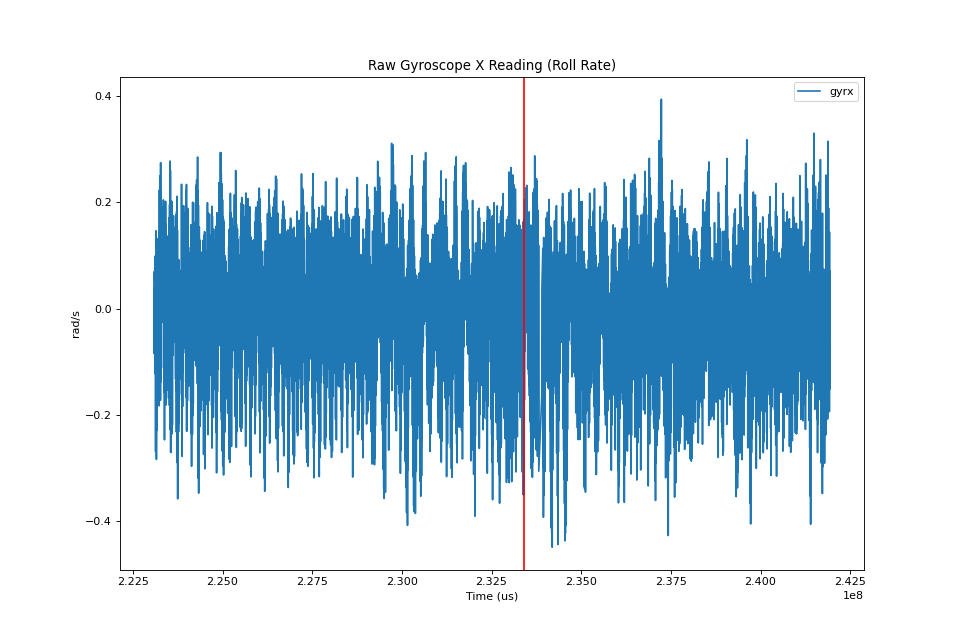

In [3]:
from confirmation.visualize import simple_time_plot

# Plotting the raw roll readings
simple_time_plot(cUS.cUS,
                 cUS.gyrx,
                 ["us","rad/s"],
                 atk=atk,
                 title="Raw Gyroscope X Reading (Roll Rate)")

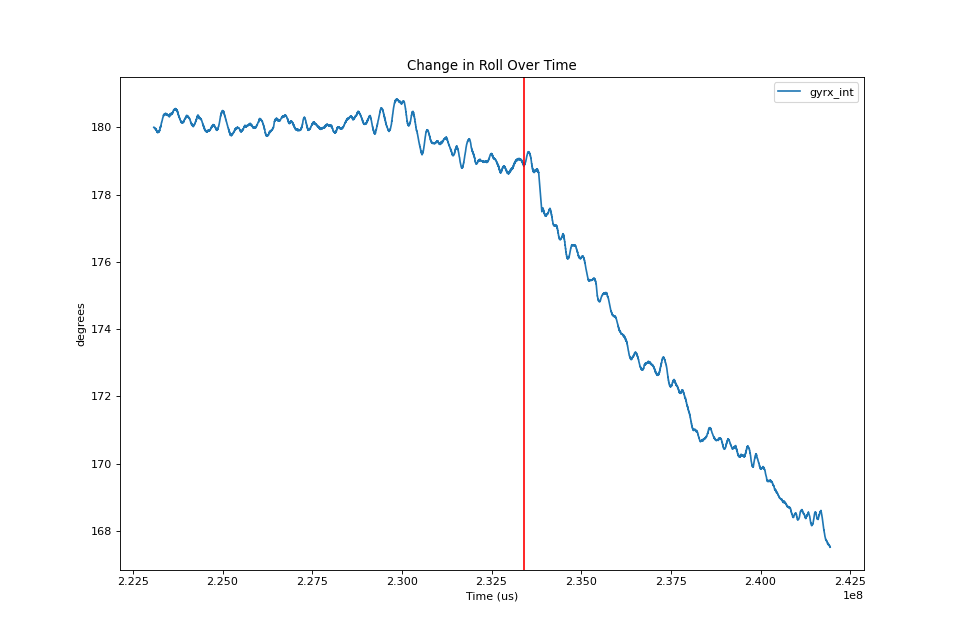

In [4]:
from confirmation.process import trap_integrate
from math import degrees

# Trapezoidal Integration of the roll readings and then cumulatively summing over time
gyr_roll = trap_integrate(cUS.cUS / 1000000, cUS.gyrx).apply(degrees).cumsum() % 360
simple_time_plot(cUS.cUS[1:],
                 (gyr_roll+180)%360,
                 ['us', 'degrees'],
                 title="Change in Roll Over Time",
                 atk=atk)

Here we can see that the roll hovers at some value of which we assume to 
represent a level quadcopter platform during the benign portion of the flight.
Since the gyroscope is a relative measurement the absolute roll will depend on
where we calibrate it to. Here since we are less concerned about the absolute
roll we simply offset the reading to make the signal easier to read.
During the attack portion the quadcopter starts veering sideways,
deviating from a level attitude and causing lateral deviation.

### Magnetometer

Magnetometer can only provide two pieces of information for confirmation with
the gyroscope and optical flow, heading and pitch. Below we will show the 
heading confirmation between magnetometer and gyroscope but will show the
pitch later on with the optical flow since it's the only common value for
all 3 sensors.

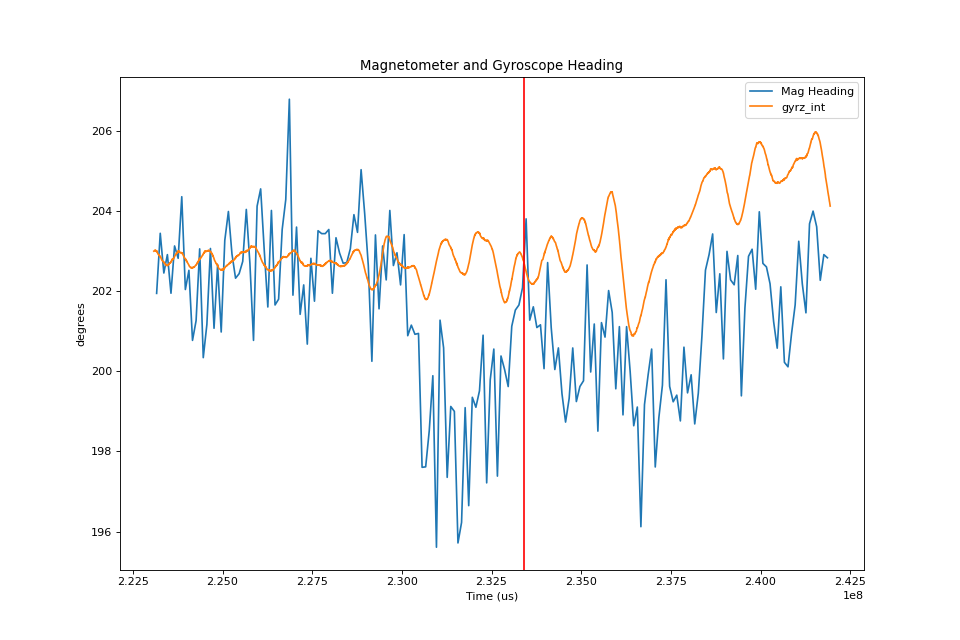

In [5]:
from confirmation.process import mag_to_pitch, mag_to_heading

# Calculating gyroscope attitudes to confirm with magnetometer
gyr_heading = trap_integrate(cUS.cUS / 1000000, cUS.gyrz).apply(degrees).cumsum() % 360
gyr_pitch = trap_integrate(cUS.cUS / 1000000, cUS.gyry).apply(degrees).cumsum() % 360

# Calculating magnetometer attitudes
mag_heading = mag_to_heading(magUS.magz, magUS.magy, magUS.magx)
mag_pitch = mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)

simple_time_plot([magUS.magUS[1:], cUS.cUS[1:]],
                 [mag_heading[1:], (gyr_heading+203)%360],
                 units=["us","degrees"],
                 title="Magnetometer and Gyroscope Heading",
                 atk=atk)

### Optical Flow

Optical Flow can only provide two pieces of information to be confirmed with
the gyroscope and magnetometer, pitch and roll.

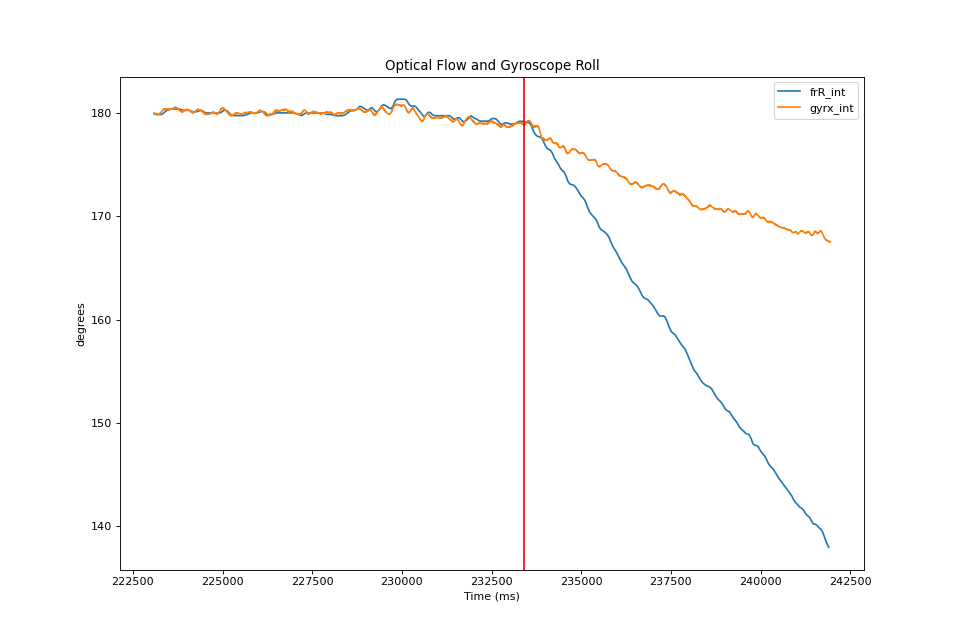

In [6]:
# Calculating optical flow change in attitude to confirm with gyroscope
of_roll = trap_integrate(ofMS.ofMS / 1000, ofMS.frR).apply(degrees).cumsum() % 360
of_pitch = trap_integrate(ofMS.ofMS / 1000, ofMS.frF).apply(degrees).cumsum() % 360

simple_time_plot([ofMS.ofMS[1:], (cUS.cUS/1000)[1:]],
                 [(of_roll+180)%360, (gyr_roll+180)%360],
                 units=["ms","degrees"],
                 title="Optical Flow and Gyroscope Roll",
                 atk=atk/1000)

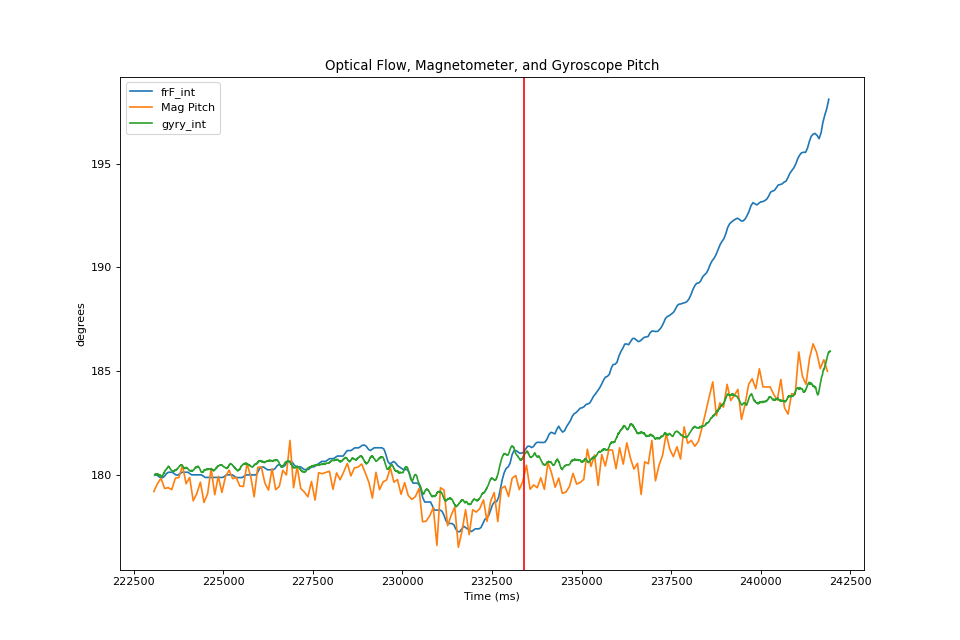

In [7]:
simple_time_plot([ofMS.ofMS[1:], (magUS.magUS/1000), (cUS.cUS/1000)[1:]],
                 [(of_pitch+180)%360, (mag_pitch-10)%360, (gyr_pitch+180)%360],
                 units=["ms","degrees"],
                 title="Optical Flow, Magnetometer, and Gyroscope Pitch",
                 atk=atk/1000)

## Statistics of These Signals Compared to Theory
We are going to look at the attitude, i.e., deg, of the pitch,
roll, and heading rather than the integrated reading to better compare the
changes in the signals.

### Gyroscope and Optical Flow

In [8]:
from confirmation.process import signal_match_and_cumsum, change_in_signal

#Matching gyroscope to the optical flow update rate
gyr_of_pitch = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_pitch+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_pitch+180) % 360))

gyr_of_pitch = pd.Series(gyr_of_pitch, name="gyr_pitch")
gyr_of_pitch = (gyr_of_pitch-180)%360
of_pitch = (of_pitch-180)%360

#Matching gyroscope to the optical flow update rate
gyr_of_roll = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_roll+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_roll+180) % 360))

gyr_of_roll = pd.Series(gyr_of_roll, name="gyr_roll")
gyr_of_roll = (gyr_of_roll+180)%360
of_roll = (of_roll+180)%360

#### Pitch

In [9]:
#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = ofMS.ofMS[ofMS.ofMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Gyroscope and OF during benign 99.7%%: %.5f degrees" % np.percentile(abs(gyr_of_pitch - of_pitch)[:atk_index].dropna(), 99.7))
print("Gyroscope and OF during attack 99.7%%: %.5f degrees" % np.percentile(abs(gyr_of_pitch - of_pitch)[atk_index:].dropna(), 99.7))

# I'm leaving this here as an interesting aside. The change in signals is actually the same during both malicious and benign flight time. It would appear that
# to detect an attacker the change over time is what is noticed, not the immediate change in signal
#print("Bar and RF during benign 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[:atk_index].dropna(), 99.7))
#print("Bar and RF during attack 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[atk_index:].dropna(), 99.7))

Gyroscope and OF during benign 99.7%: 1.55478 degrees
Gyroscope and OF during attack 99.7%: 12.34267 degrees


#### Roll

In [10]:
#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Gyroscope and OF during benign 99.7%%: %.5f degrees" % np.percentile(abs(gyr_of_roll - of_roll)[:atk_index].dropna(), 99.7))
print("Gyroscope and OF during attack 99.7%%: %.5f degrees" % np.percentile(abs(gyr_of_roll - of_roll)[atk_index:].dropna(), 99.7))

# I'm leaving this here as an interesting aside. The change in signals is actually the same during both malicious and benign flight time. It would appear that
# to detect an attacker the change over time is what is noticed, not the immediate change in signal
#print("Bar and RF during benign 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[:atk_index].dropna(), 99.7))
#print("Bar and RF during attack 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[atk_index:].dropna(), 99.7))

Gyroscope and OF during benign 99.7%: 0.92270 degrees
Gyroscope and OF during attack 99.7%: 29.44447 degrees


### Magnetometer and Optical Flow
The only axis to confirm between the magnetometer and optical flow is the 
pitch. The confirmation for pitch is shown below

#### Pitch

In [11]:
#Matching gyroscope to the optical flow update rate
of_mag_pitch = signal_match_and_cumsum(ofMS.ofMS[2:].reset_index(drop=True), change_in_signal(of_pitch),
                                       magUS.magUS[1:].reset_index(drop=True)/1000, change_in_signal(mag_pitch))

of_mag_pitch = pd.Series(of_mag_pitch, name="of_pitch")
of_mag_pitch = of_mag_pitch + 189.5

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = magUS.magUS[magUS.magUS < atk][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and RF during benign 99.7%%: %.5f degrees" % np.percentile(abs(of_mag_pitch - mag_pitch)[:atk_index].dropna(), 99.7))
print("Bar and RF during attack 99.7%%: %.5f degrees" % np.percentile(abs(of_mag_pitch - mag_pitch)[atk_index:].dropna(), 99.7))

# I'm leaving this here as an interesting aside. The change in signals is actually the same during both malicious and benign flight time. It would appear that
# to detect an attacker the change over time is what is noticed, not the immediate change in signal
#print("Bar and RF during benign 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[:atk_index].dropna(), 99.7))
#print("Bar and RF during attack 99.7%%: %.5f deg/s" % np.percentile(abs(change_in_signal(gyr_of_pitch) - change_in_signal(of_pitch))[atk_index:].dropna(), 99.7))

Bar and RF during benign 99.7%: 2.11600 degrees
Bar and RF during attack 99.7%: 11.90258 degrees


### Magnetometer and Gyroscope
These 2 sensors represent the benign sensors. Ideally we will see similar
results during both the benign and malicious portions of the dataset.

#### Pitch

In [12]:
#Matching gyroscope to the optical flow update rate
gyr_mag_pitch = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_pitch+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_pitch))

gyr_mag_pitch = pd.Series(gyr_mag_pitch, name="gyr_pitch")
gyr_mag_pitch = gyr_mag_pitch + 189.5

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = magUS.magUS[magUS.magUS < atk][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and RF during benign 99.7%%: %.5f degrees" % np.percentile(abs(gyr_mag_pitch - mag_pitch)[:atk_index].dropna(), 99.7))
print("Bar and RF during attack 99.7%%: %.5f degrees" % np.percentile(abs(gyr_mag_pitch - mag_pitch)[atk_index:].dropna(), 99.7))

Bar and RF during benign 99.7%: 2.40333 degrees
Bar and RF during attack 99.7%: 2.76011 degrees


#### Heading

In [13]:
#Matching gyroscope to the optical flow update rate
gyr_mag_heading = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_heading+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_heading))

gyr_mag_heading = pd.Series(gyr_mag_heading, name="gyr_heading")
gyr_mag_heading = gyr_mag_heading + 201

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = magUS.magUS[magUS.magUS < atk][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and RF during benign 99.7%%: %.5f degrees" % np.percentile(abs(gyr_mag_heading - mag_heading)[:atk_index].dropna(), 99.7))
print("Bar and RF during attack 99.7%%: %.5f degrees" % np.percentile(abs(gyr_mag_heading - mag_heading)[atk_index:].dropna(), 99.7))

Bar and RF during benign 99.7%: 5.69703 degrees
Bar and RF during attack 99.7%: 3.72214 degrees


## Conclusion

A quick summary of the results we have seen:

|             **Confirmations**            | **Benign**<br> difference in degrees| **Malicious** <br> difference in degrees|
|:----------------------------------------:|:----------:|:-------------:|
| **Gyroscope and OF (Pitch)**             |    1.55    |      12.3     |
| **Gyroscope and OF (Roll)**              |    0.922   |      29.4     |
| **Magnetometer and OF (Pitch)**          |    2.12    |      11.9     |
| **Magnetometer and Gyroscope (Pitch)**   |    2.40    |      2.76     |
| **Magnetometer and Gyroscope (Heading)** |    5.70    |      3.72     |

The bottom 2 rows indicate the benign case. Overall we see a large disagreement
between the attacked optical flow sensor and the paired benign sensors. This
indicates, at least for a loitered vehicle, that there should be room for
sensor confirmation to detect an attack without flagging a benign flight.